#Imports

In [1]:
! pip install -q tensorflow-text
! pip install tensorflow_addons
! pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 16.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 88.2 MB/s eta 0:00:00


In [2]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import tqdm
pd.set_option('display.width', 3000)
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
import keras
from keras import regularizers
import re
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm_notebook
tqdm_notebook().pandas()
import tqdm
#from pandarallel import pandarallel
from tqdm.notebook import tqdm
tqdm.pandas()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0it [00:00, ?it/s]

#Prepare codeswitch data

In [5]:
import pandas as pd
df_dic = pd.read_csv("./drive/MyDrive/Thesis/Dictionary.csv")

In [6]:
df_dic.head(5)

,Arabic,English
0,سبب,reason
1,تكرار,repeating
2,التجربة,the experiment
3,ستحتاج,needs
4,النتائج,results


In [7]:
arabic = df_dic.Arabic.values
english = df_dic.English.values
english.shape

(30,)

In [8]:
def switch(text):
  try:
    new = []   
    text = text.split() 
    for word in text :
     translation = ""
     for i in range(0,len(arabic)) :
       if word == arabic[i] :
         translation = english[i]
         break       
     if translation != "" :
       new.append(translation)
     else:
       new.append(word)
  except: 
          pass

  newText = ' '.join([str(elem) for i,elem in enumerate(new)])
  return newText


In [9]:
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

In [10]:
def CountEnglish(text):
  english_words = 0
  try:
    text = text.split()  
    for word in text :
      if(isEnglish(word)) :
        english_words += 1
  except: 
          pass

  return english_words

def CountTotalW(text):
  words = 0
  try:
    text = text.split()  
    for word in text :
      words += 1
  except: 
          pass
          
  return words


In [11]:
def sum(numm) :
  r = 0
  for i in range(len(numm)) :
    r+=numm[i]
  return r

In [12]:
import string,re
punctuation = string.punctuation + "؟'«»٫٬،.؛"
def remove_punctuation(text):
  return text.translate(str.maketrans('', '', punctuation))
def remove_extra_space(text):
  return re.sub(' +', ' ', text)

In [13]:
def read_csv(question):
  df = pd.read_csv("./drive/MyDrive/Thesis/sas-ar.csv")
  df.dropna(inplace=True)
  df = df[df['EssaySet']==question]
  return df
  

In [14]:
def embed_text(df):
  embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")
  # test = df[df['EssaySet']==1]
  X = np.array(embed(df["EssayText"]))
  print(X.shape)  
  y = np.array(df["Score1"])
  return X,y

#Read Whole data

In [15]:

def whole_data():
  df = pd.read_csv("./drive/MyDrive/Thesis/sas-ar.csv")
  df.dropna(inplace=True)

  df['EssayText'] = df['EssayText'].progress_apply(lambda text: switch(text))

  df['English_Words'] = df['EssayText'].progress_apply(lambda text: CountEnglish(text))
  df['Total_Words'] = df['EssayText'].progress_apply(lambda text: CountTotalW(text))
  
  CodeSwitch_Percentage = []
  englishWords = df.English_Words.values
  totalWords = df.Total_Words.values
  CodeSwitch_Percentage.append( (englishWords/totalWords)*100  )
  codeSwitchPercentages = CodeSwitch_Percentage[0]
  df['CodeSwitch_Percentage'] = codeSwitchPercentages


  English = sum(englishWords)
  Words = sum(totalWords)
  print("English is : " , English," out of total number of words: ", Words)
  print("CodeSwitch percentage is : ",  (English/Words)*100 , "%" )


  df["EssayText"] = df["EssayText"].apply(lambda text: remove_punctuation(text))
  df["EssayText"] = df["EssayText"].apply(lambda text: remove_extra_space(text))

  embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")
  test = df[df['EssaySet']==1]
  X = np.array(embed(test["EssayText"]))
  for i in range(2,11):
    test = df[df['EssaySet']==i]
    curr = np.array(embed(test["EssayText"]))
    X = np.concatenate((X,curr), axis=0)
  y = np.array(df["Score1"])
  essaySet = np.array(df['EssaySet'])
  essaySet = np.expand_dims(essaySet,axis=1)/100
  X = np.concatenate((essaySet,X), axis=1)  
  X = np.expand_dims(X,axis=1)

 
  X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df[["EssaySet","Score1"]] ,test_size=0.2, random_state=42)
  print(X_train.shape)
  return X_train, X_test, y_train, y_test


In [16]:
X_train, X_test, y_train, y_test = whole_data()

  0%|          | 0/17043 [00:00<?, ?it/s]

  0%|          | 0/17043 [00:00<?, ?it/s]

  0%|          | 0/17043 [00:00<?, ?it/s]

English is :  51623  out of total number of words:  617962
CodeSwitch percentage is :  8.353749906952206 %
(13634, 1, 513)


#Run Individually

In [19]:
df = read_csv(1)

df['EssayText'] = df['EssayText'].progress_apply(lambda text: switch(text))



df['English_Words'] = df['EssayText'].progress_apply(lambda text: CountEnglish(text))
df['Total_Words'] = df['EssayText'].progress_apply(lambda text: CountTotalW(text))

CodeSwitch_Percentage = []
englishWords = df.English_Words.values
totalWords = df.Total_Words.values
CodeSwitch_Percentage.append( (englishWords/totalWords)*100  )
codeSwitchPercentages = CodeSwitch_Percentage[0]
df['CodeSwitch_Percentage'] = codeSwitchPercentages


Words = sum(totalWords)
English = sum(englishWords)

print("English is : " , English," out of total number of words: ", Words)
print("CodeSwitch percentage is : ",  (English/Words)*100 , "%" )

df["EssayText"] = df["EssayText"].apply(lambda text: remove_punctuation(text))
df["EssayText"] = df["EssayText"].apply(lambda text: remove_extra_space(text))

  0%|          | 0/1672 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

English is :  8135  out of total number of words:  64845
CodeSwitch percentage is :  12.545300331559876 %


In [20]:
df.head(5)

,Id,EssaySet,Score1,Score2,EssayText,English_Words,Total_Words,CodeSwitch_Percentage
0,1,1,1,1,بعض المعلومات extra التي سنحتاجها for repeatin...,6,46,13.043478
1,2,1,1,1,بعد قراءة تاريخ انتهاء الصلاحية أدركت أن المعل...,6,47,12.765957
2,3,1,1,1,ما تحتاجه هو المزيد من التجارب وإعدادات تحكم و...,6,31,19.354839
3,4,1,0,0,يجب على student أن يذكر الصخرة الأفضل وما هي ا...,1,13,7.692308
4,5,1,2,2,لكي يتمكن the students من عمل نسخة مكررة سيحتا...,3,22,13.636364


In [21]:
X,y = embed_text(df)
X = np.expand_dims(X,axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y ,test_size=0.2, random_state=42)
print(np.unique(y_train, return_counts=True))

(1672, 512)
(array([0, 1, 2, 3]), array([304, 343, 419, 271]))


In [22]:
df.shape

(1672, 8)

In [23]:
newAns = df.EssayText.values

#LSTM

In [26]:
tf.keras.backend.clear_session()
epochs = 5000
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
lstm_model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1,512)),
        tf.keras.layers.LSTM(128,activation="sigmoid", return_sequences=True, recurrent_dropout=0.2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(64 ,activation="sigmoid", recurrent_dropout=0.2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(4, activation="softmax"),
])
op = keras.optimizers.Adam(learning_rate=0.0001)
loss = keras.losses.SparseCategoricalCrossentropy()
lstm_model.compile(optimizer=op,
              loss=loss,
              metrics=[tfa.metrics.CohenKappa(weightage="quadratic", sparse_labels=True, num_classes=4)])
lstm_history = lstm_model.fit(X_train, y_train,epochs=epochs, validation_split=0.1, batch_size=64, callbacks=[callback], shuffle=True)

Epoch 1/5000


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


19/19 [==============================] - 6s 61ms/step - loss: 1.4726 - cohen_kappa: 0.0154 - val_loss: 1.4425 - val_cohen_kappa: 0.0000e+00
Epoch 2/5000
19/19 [==============================] - 0s 17ms/step - loss: 1.4379 - cohen_kappa: 0.0158 - val_loss: 1.4171 - val_cohen_kappa: 0.0000e+00
Epoch 3/5000
19/19 [==============================] - 0s 18ms/step - loss: 1.4300 - cohen_kappa: -0.0097 - val_loss: 1.3977 - val_cohen_kappa: 0.0000e+00
Epoch 4/5000
19/19 [==============================] - 0s 16ms/step - loss: 1.4159 - cohen_kappa: 0.0094 - val_loss: 1.3845 - val_cohen_kappa: 0.0000e+00
Epoch 5/5000
19/19 [==============================] - 0s 17ms/step - loss: 1.4090 - cohen_kappa: -0.0210 - val_loss: 1.3744 - val_cohen_kappa: 0.0000e+00
Epoch 6/5000
19/19 [==============================] - 0s 18ms/step - loss: 1.3971 - cohen_kappa: 0.0093 - val_loss: 1.3681 - val_cohen_kappa: 0.2733
Epoch 7/5000
19/19 [==============================] - 0s 16ms/step - loss: 1.3919 - cohen_kappa: 

In [27]:
print(lstm_model.evaluate(X_test,y_test))

11/11 [==============================] - 0s 5ms/step - loss: 0.8919 - cohen_kappa: 0.7358
[0.8918745517730713, 0.7357909679412842]


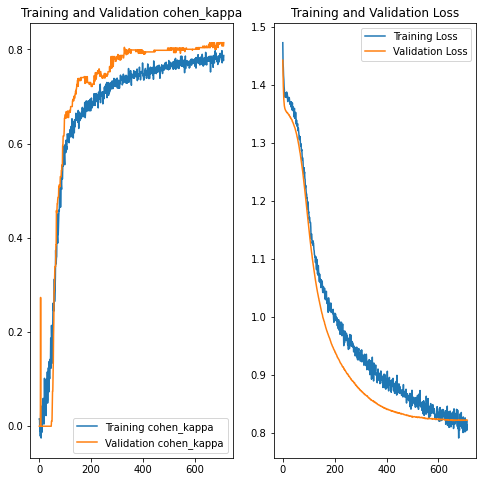

In [28]:
training_accuracy = lstm_history.history['cohen_kappa']
validation_accuracy = lstm_history.history['val_cohen_kappa']

training_loss = lstm_history.history['loss']
validation_loss = lstm_history.history['val_loss']

epochs_range=range(len(lstm_history.epoch))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training cohen_kappa')
plt.plot(epochs_range, validation_accuracy, label='Validation cohen_kappa')
plt.legend(loc='lower right')
plt.title('Training and Validation cohen_kappa')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#RNN

In [29]:
tf.keras.backend.clear_session()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
epoch = 5000
rnn_model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1,512)),
        tf.keras.layers.SimpleRNN(128,activation="sigmoid", return_sequences=True),
        tf.keras.layers.Dropout(.2),
        tf.keras.layers.SimpleRNN(64 ,activation="sigmoid"),
        tf.keras.layers.Dropout(.2),
        tf.keras.layers.Dense(4, activation="softmax"),
])
op = keras.optimizers.Adam(learning_rate=0.0001)
loss = keras.losses.SparseCategoricalCrossentropy()
rnn_model.compile(optimizer=op,
              loss=loss,
              metrics=[tfa.metrics.CohenKappa(num_classes=4, sparse_labels=True, weightage="quadratic")])
rnn_history = rnn_model.fit(X_train, y_train,epochs=epoch, validation_split=0.1, batch_size=32, callbacks=[callback])

Epoch 1/5000
38/38 [==============================] - 3s 20ms/step - loss: 1.5190 - cohen_kappa: 0.0048 - val_loss: 1.4515 - val_cohen_kappa: 0.0000e+00
Epoch 2/5000
38/38 [==============================] - 0s 6ms/step - loss: 1.4355 - cohen_kappa: 0.0465 - val_loss: 1.3895 - val_cohen_kappa: 0.0000e+00
Epoch 3/5000
38/38 [==============================] - 0s 7ms/step - loss: 1.4143 - cohen_kappa: -0.0075 - val_loss: 1.3634 - val_cohen_kappa: 0.1157
Epoch 4/5000
38/38 [==============================] - 0s 7ms/step - loss: 1.4027 - cohen_kappa: 0.0064 - val_loss: 1.3562 - val_cohen_kappa: 0.0000e+00
Epoch 5/5000
38/38 [==============================] - 0s 6ms/step - loss: 1.4159 - cohen_kappa: -0.0078 - val_loss: 1.3532 - val_cohen_kappa: 0.0000e+00
Epoch 6/5000
38/38 [==============================] - 0s 6ms/step - loss: 1.4131 - cohen_kappa: 0.0130 - val_loss: 1.3513 - val_cohen_kappa: 0.0000e+00
Epoch 7/5000
38/38 [==============================] - 0s 6ms/step - loss: 1.3932 - cohen_

In [30]:
print(rnn_model.evaluate(X_test,y_test))

11/11 [==============================] - 0s 3ms/step - loss: 0.8780 - cohen_kappa: 0.7351
[0.8779817819595337, 0.7351467609405518]


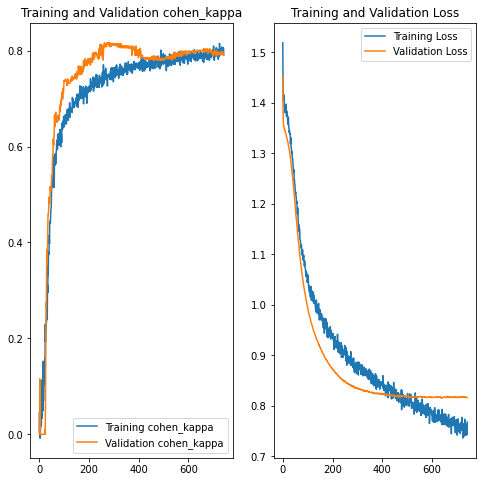

In [31]:
training_accuracy = rnn_history.history['cohen_kappa']
validation_accuracy = rnn_history.history['val_cohen_kappa']

training_loss = rnn_history.history['loss']
validation_loss = rnn_history.history['val_loss']

epochs_range=range(len(rnn_history.epoch))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training cohen_kappa')
plt.plot(epochs_range, validation_accuracy, label='Validation cohen_kappa')
plt.legend(loc='lower right')
plt.title('Training and Validation cohen_kappa')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#Bi-Directional

In [32]:
epochs = 3000
tf.keras.backend.clear_session()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
bi_model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1,512)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,activation="sigmoid", return_sequences=True)),
        tf.keras.layers.Dropout(.2),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64 ,activation="sigmoid")),
        tf.keras.layers.Dropout(.2),
        tf.keras.layers.Dense(4, activation="softmax"),
])
op = keras.optimizers.Adam(learning_rate=0.0001)
loss = keras.losses.SparseCategoricalCrossentropy()
bi_model.compile(optimizer=op,
              loss=loss,
              metrics=[tfa.metrics.CohenKappa(weightage="quadratic", sparse_labels=True, num_classes=4),"accuracy"])
bi_history = bi_model.fit(X_train, y_train,epochs=epochs, validation_split=0.1, batch_size=64, shuffle=True, callbacks=[callback])

Epoch 1/3000
19/19 [==============================] - 7s 71ms/step - loss: 1.4155 - cohen_kappa: -0.0397 - accuracy: 0.2319 - val_loss: 1.3899 - val_cohen_kappa: 0.0000e+00 - val_accuracy: 0.2313
Epoch 2/3000
19/19 [==============================] - 0s 21ms/step - loss: 1.3997 - cohen_kappa: 0.0154 - accuracy: 0.2652 - val_loss: 1.3675 - val_cohen_kappa: 0.0000e+00 - val_accuracy: 0.3582
Epoch 3/3000
19/19 [==============================] - 0s 20ms/step - loss: 1.3953 - cohen_kappa: 0.0043 - accuracy: 0.2685 - val_loss: 1.3588 - val_cohen_kappa: 0.0000e+00 - val_accuracy: 0.3582
Epoch 4/3000
19/19 [==============================] - 0s 23ms/step - loss: 1.3896 - cohen_kappa: 0.0544 - accuracy: 0.2926 - val_loss: 1.3575 - val_cohen_kappa: 0.0000e+00 - val_accuracy: 0.3582
Epoch 5/3000
19/19 [==============================] - 0s 24ms/step - loss: 1.3831 - cohen_kappa: 0.0299 - accuracy: 0.3084 - val_loss: 1.3572 - val_cohen_kappa: 0.0000e+00 - val_accuracy: 0.3582
Epoch 6/3000
19/19 [====

In [33]:
print(bi_model.evaluate(X_test,y_test))

11/11 [==============================] - 0s 7ms/step - loss: 0.8861 - cohen_kappa: 0.7338 - accuracy: 0.6328
[0.8861266374588013, 0.7337713241577148, 0.6328358054161072]


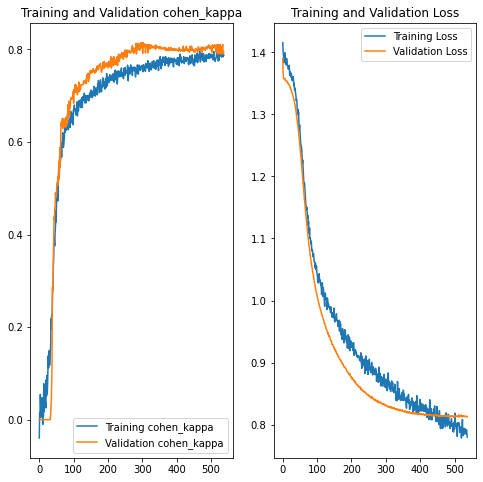

In [34]:
training_accuracy = bi_history.history['cohen_kappa']
validation_accuracy = bi_history.history['val_cohen_kappa']

training_loss = bi_history.history['loss']
validation_loss = bi_history.history['val_loss']

epochs_range=range(len(bi_history.epoch))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training cohen_kappa')
plt.plot(epochs_range, validation_accuracy, label='Validation cohen_kappa')
plt.legend(loc='lower right')
plt.title('Training and Validation cohen_kappa')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()